In [3]:
import numpy as np
from chmm_actions import CHMM
import matplotlib.pyplot as plt

# Training a CHMM

In [2]:
# Train CHMM on random data
TIMESTEPS = 1000
OBS = 2
x = np.random.randint(OBS, size=(1000,)) # Observations. Replace with your data.
a = np.zeros(1000, dtype=np.int64) # If there are actions in your domain replace this. If not, keep the vector of zeros.
n_clones = np.ones(OBS, dtype=np.int64) * 5 # Number of clones specifies the capacity for each observation. 

x_test = np.random.randint(OBS, size=(1000,)) # Test observations. Replace with your data.
a_test = np.zeros(1000, dtype=np.int64)

chmm = CHMM(n_clones=n_clones, pseudocount=1e-10, x=x, a=a) # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100, term_early=False) # Training

nll_per_prediction = chmm.bps(x_test, a_test) # Evaluate negative log-likelihood (base 2 log)
avg_nll = np.mean(nll_per_prediction)
avg_prediction_probability = 2**(-avg_nll)
print(avg_prediction_probability)

Average number of clones: 5.0


100%|██████████| 100/100 [00:03<00:00, 29.41it/s, train_bps=0.998]


0.4996067139958269


# Rectangular room datagen

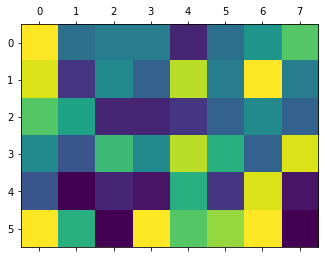

In [12]:
def rectangular_room_datagen(H=6, W=8, n_emissions=20, length=10000):
    room = np.random.randint(n_emissions, size=(H, W))
    actions = np.random.randint(4, size=length)  # 0: left, 1: right, 2: up, 3: down
    x = np.zeros(length, int)
    rc = np.zeros((length, 2), int)
    r, c = np.random.randint(H), np.random.randint(W)
    x[0] = room[r, c]
    rc[0] = r, c
    for i, a in enumerate(actions[:-1]):
        if a == 0 and 0 < c:
            c -= 1
        elif a == 1 and c < W - 1:
            c += 1
        elif a == 2 and 0 < r:
            r -= 1
        elif a == 3 and r < H - 1:
            r += 1
            x[i + 1] = room[r, c]
        x[i + 1] = room[r, c]
        rc[i + 1] = r, c
    return room, actions, x, rc

n_emissions=20
room, a, x, rc = rectangular_room_datagen(n_emissions=n_emissions)
plt.matshow(room)

n_clones = np.ones(n_emissions, dtype=np.int64) * 10
chmm = CHMM(n_clones=n_clones, pseudocount=1e-10, x=x, a=a) # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100, term_early=False) # Training

# Empty rectangular room datagen

Average number of clones: 40.0


100%|██████████| 100/100 [00:10<00:00,  9.60it/s, train_bps=0.0531]


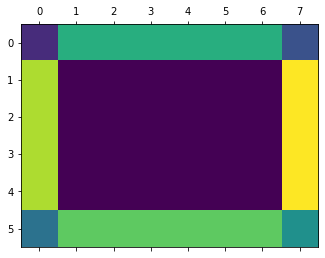

In [6]:
def empty_rectangular_room_datagen(H=6, W=8, length=10000):
    room = np.zeros((H, W),dtype=np.int64)
    room[:] = 0
    room[0] = 5
    room[-1] = 6
    room[:, 0] = 7
    room[:, -1] = 8
    room[0, 0] = 1
    room[0, -1] = 2
    room[-1, 0] = 3
    room[-1, -1] = 4
    actions = np.random.randint(4, size=length)  # 0: left, 1: right, 2: up, 3: down
    x = np.zeros(length, int)
    rc = np.zeros((length, 2), int)
    r, c = np.random.randint(H), np.random.randint(W)
    x[0] = room[r, c]
    rc[0] = r, c
    for i, a in enumerate(actions[:-1]):
        if a == 0 and 0 < c:
            c -= 1
        elif a == 1 and c < W - 1:
            c += 1
        elif a == 2 and 0 < r:
            r -= 1
        elif a == 3 and r < H - 1:
            r += 1
            x[i + 1] = room[r, c]
        x[i + 1] = room[r, c]
        rc[i + 1] = r, c
    return room, actions, x, rc


room, a, x, rc = empty_rectangular_room_datagen()
plt.matshow(room)

n_clones = np.ones(9, dtype=np.int64) * 40
chmm = CHMM(n_clones=n_clones, pseudocount=1e-10, x=x, a=a) # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100, term_early=False) # Training

# 3 Pentagon cliques

Average number of clones: 40.0


100%|██████████| 100/100 [00:10<00:00,  9.94it/s, train_bps=1.77]


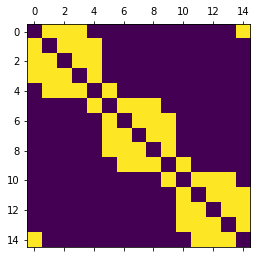

In [7]:
T = np.zeros((15,15))
# Connect cliques
for i in range(0,4+1):
    for j in range(0,4+1):
        if i!=j:
            T[i,j] = 1.0
for i in range(5,9+1):
    for j in range(5,9+1):
        if i!=j:
            T[i,j] = 1.0
for i in range(10,14+1):
    for j in range(10,14+1):
        if i!=j:
            T[i,j] = 1.0
# Disconnect in clique connector nodes
T[0,4] = 0.0
T[4,0] = 0.0
T[5,9] = 0.0
T[9,5] = 0.0
T[10,14] = 0.0
T[14,10] = 0.0
# Connect cross clique connector nodes
T[4,5] = 1.0
T[5,4] = 1.0
T[9,10] = 1.0
T[10,9] = 1.0
T[14,0] = 1.0
T[0,14] = 1.0
plt.matshow(T)

# Draw data
states = [0]
for _ in range(10000):
    prev_state = states[-1]
    
    possible_next_states = np.where(T[prev_state,:])[0]
    next_state = np.random.choice(possible_next_states)
    states.append(next_state)
states = np.array(states)

state_to_obs = np.array([1,2,3,4,5,6,1,4,5,2,8,2,3,5,7], dtype=int) - 1 # Aliasing version

# Create observation data
x = state_to_obs[states]
a = np.zeros(len(x),dtype=int)

n_clones = np.ones(8, dtype=np.int64) * 40
chmm = CHMM(n_clones=n_clones, pseudocount=1e-10, x=x, a=a) # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100, term_early=False) # Training

# 5x5 mazes

In [1]:
def fivebyfive_room_datagen(length=10000):
    room = np.random.permutation(25).reshape(5,5)
    H,W = 5,5
    actions = np.random.randint(4, size=length)  # 0: left, 1: right, 2: up, 3: down
    x = np.zeros(length, int)
    rc = np.zeros((length, 2), int)
    r, c = np.random.randint(H), np.random.randint(W)
    x[0] = room[r, c]
    rc[0] = r, c
    for i, a in enumerate(actions[:-1]):
        if a == 0 and 0 < c:
            c -= 1
        elif a == 1 and c < W - 1:
            c += 1
        elif a == 2 and 0 < r:
            r -= 1
        elif a == 3 and r < H - 1:
            r += 1
            x[i + 1] = room[r, c]
        x[i + 1] = room[r, c]
        rc[i + 1] = r, c
    return room, actions, x, rc

room, a, x, rc = fivebyfive_room_datagen()
plt.matshow(room)

n_clones = np.ones(25, dtype=np.int64) * 2
chmm = CHMM(n_clones=n_clones, pseudocount=1e-10, x=x, a=a) # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100, term_early=False) # Training

NameError: name 'np' is not defined

# Two Rooms Stitched Together

In [7]:
room2 = np.array([[11,11, 4,11,12, 3],
                  [ 1, 9,11,12,14,12],
                  [ 9, 4, 2, 7,14, 0],
                  [11, 2, 8, 9, 0, 0],
                  [ 2, 9, 6, 8,13, 8],
                  [14, 2,13, 4, 5, 0],
                  [14, 9, 7,13, 4,14],
                  [ 0, 3,13, 3, 1,11]])


room1 = np.array([[ 2,13, 1,  0,  4,12],
                  [10, 0, 11,12, 3, 7],
                  [ 4, 9, 12,14,12, 5],
                  [ 8, 4, 7, 14, 0, 5],
                  [ 1,13, 2,  7,10, 4],
                  [11,12, 3,  8,14, 3],
                  [12,14,12,  5, 1, 1],
                  [ 7,14, 0,  3, 9, 5]])

def datagen(room, H=6, W=8, length=10000):
    actions = np.random.randint(4, size=length)  # 0: left, 1: right, 2: up, 3: down
    x = np.zeros(length, int)
    rc = np.zeros((length, 2), int)
    r, c = np.random.randint(H), np.random.randint(W)
    x[0] = room[r, c]
    rc[0] = r, c
    for i in range(len(actions)-1):
        a = actions[i]
        done = False
        while not done:
            done = True
            if a == 0 and 0 < c:
                c -= 1
            elif a == 1 and c < W - 1:
                c += 1
            elif a == 2 and 0 < r:
                r -= 1
            elif a == 3 and r < H - 1:
                r += 1
            else:
                a = np.random.randint(4)
                done = False
        actions[i] = a
        x[i + 1] = room[r, c]
        rc[i + 1] = r, c
    return actions, x, rc
a1, x1, rc1 = datagen(room1, H=8, W=6, length=20000)
a2, x2, rc2 = datagen(room2, H=8, W=6, length=20000)

x = np.hstack((0, x1+1, 0, x2+1))
a = np.hstack((4, a1[:-1], 4, 4, a2))

n_emissions = x.max()+1

n_clones = 20*np.ones(n_emissions,int)
n_clones[0] = 1
chmm = CHMM(n_clones=n_clones, pseudocount=1e-10, x=x, a=a) # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100, term_early=False) # Training

Average number of clones: 18.8125


100%|██████████| 100/100 [00:17<00:00,  5.70it/s, train_bps=0.000256]
